<a href="https://colab.research.google.com/github/Bangalhbn/deeplearn/blob/main/klasifikasi_kelapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!kaggle datasets download awaludinharbelubun/dl-awal
!mkdir dataset

 97% 113M/116M [00:03<00:00, 34.8MB/s]
100% 116M/116M [00:03<00:00, 32.2MB/s]


In [ ]:
!unzip /content/dl-awal.zip -d /content/dataset

In [4]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

In [5]:
dataset_path = Path(r'/content/dataset')
file_path = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [6]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()

,image,label
0,/content/dataset/daset/data_2_100/berondol_1_1...,data_2_100
1,/content/dataset/daset/data_2_100/berondol_1_1...,data_2_100
2,/content/dataset/daset/data_2_100/berondol_1_2...,data_2_100
3,/content/dataset/daset/data_2_100/berondol_1_2...,data_2_100
4,/content/dataset/daset/data_2_100/berondol_1_2...,data_2_100


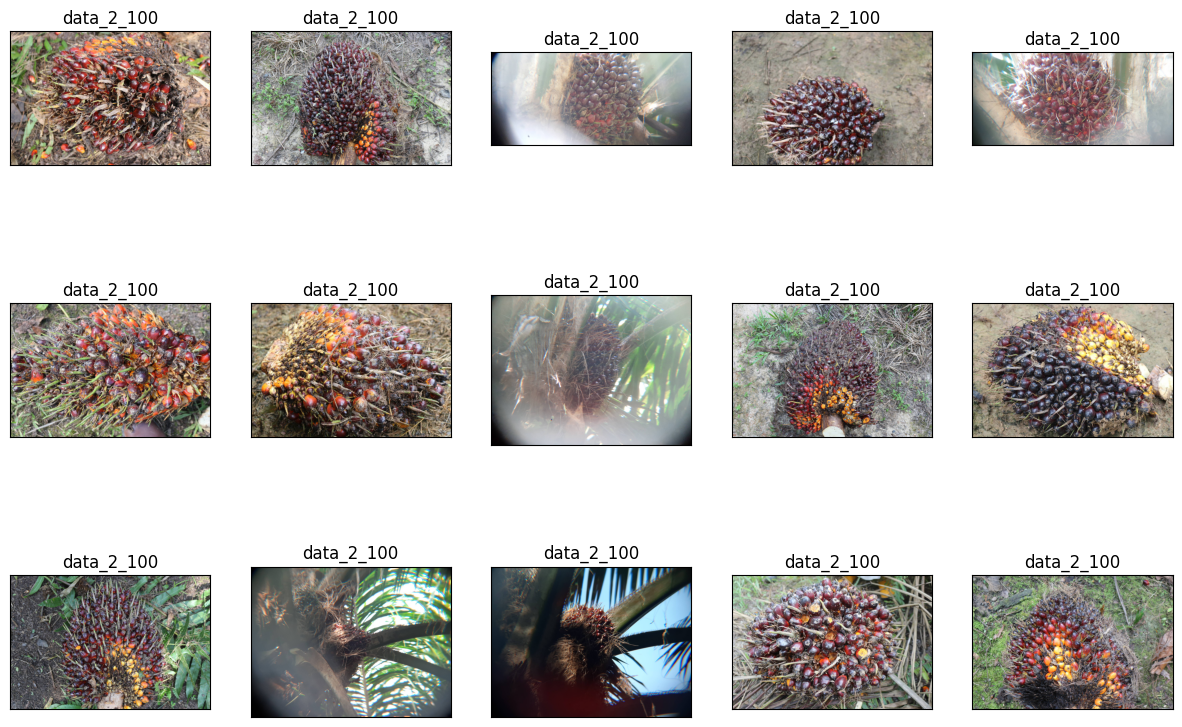

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [8]:
df.label.value_counts()

data_2_100    200
data_3_100    200
data_1_100    100
Name: label, dtype: int64

In [9]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

data_2_100    200
data_3_100    200
data_1_100    100
Name: label, dtype: int64

In [10]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [11]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (280, 2)
Shape of test data (150, 2)
Shape of validation data (70, 2)


In [12]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 280 validated image filenames belonging to 3 classes.
Found 150 validated image filenames belonging to 3 classes.
Found 70 validated image filenames belonging to 3 classes.


In [13]:
input_shape = (200, 200, 3)

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [15]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, batch_size= 512, validation_data=val, epochs=100, callbacks=callback)

Epoch 1/100
9/9 [==============================] - 29s 2s/step - loss: 1.0960 - accuracy: 0.3714 - val_loss: 1.0503 - val_accuracy: 0.4143
Epoch 2/100
9/9 [==============================] - 17s 2s/step - loss: 1.0599 - accuracy: 0.4750 - val_loss: 1.0530 - val_accuracy: 0.4143
Epoch 3/100
9/9 [==============================] - 14s 2s/step - loss: 1.0609 - accuracy: 0.4143 - val_loss: 1.0625 - val_accuracy: 0.5286
Epoch 4/100
9/9 [==============================] - 14s 2s/step - loss: 1.0540 - accuracy: 0.4643 - val_loss: 1.0275 - val_accuracy: 0.4857
Epoch 5/100
9/9 [==============================] - 14s 2s/step - loss: 1.0250 - accuracy: 0.5071 - val_loss: 1.0010 - val_accuracy: 0.6000
Epoch 6/100
9/9 [==============================] - 14s 2s/step - loss: 0.9949 - accuracy: 0.5357 - val_loss: 1.0132 - val_accuracy: 0.6143
Epoch 7/100
9/9 [==============================] - 14s 2s/step - loss: 0.9857 - accuracy: 0.5500 - val_loss: 1.0112 - val_accuracy: 0.6143
Epoch 8/100
9/9 [==========

In [16]:
model.save('model-1.h5')

In [17]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

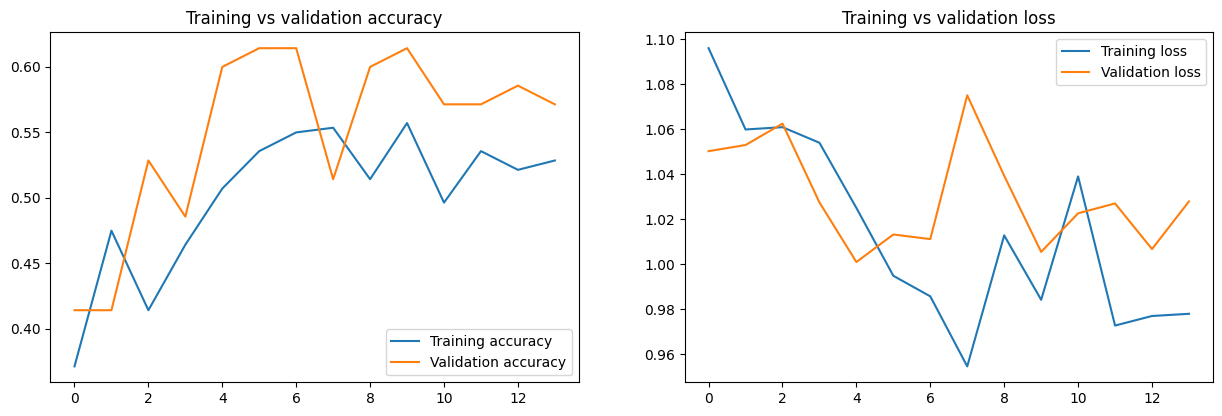

In [18]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()

In [19]:
pred = model.predict(test)

5/5 [==============================] - 7s 2s/step


In [20]:
pred = np.argmax(pred, axis=1)

In [21]:
labels = train.class_indices

In [22]:
labels

{'data_1_100': 0, 'data_2_100': 1, 'data_3_100': 2}

In [23]:
labels = dict((v,k) for k, v in labels.items())

In [24]:
labels

{0: 'data_1_100', 1: 'data_2_100', 2: 'data_3_100'}

In [25]:
y_pred = [labels[k] for k in pred]

In [26]:
print(classification_report(x_test.label, y_pred))

              precision    recall  f1-score   support

  data_1_100       0.00      0.00      0.00        30
  data_2_100       0.74      0.84      0.79        64
  data_3_100       0.62      0.86      0.72        56

    accuracy                           0.68       150
   macro avg       0.45      0.57      0.50       150
weighted avg       0.55      0.68      0.61       150



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
print(confusion_matrix(x_test.label, y_pred))

[[ 0 11 19]
 [ 0 54 10]
 [ 0  8 48]]


In [28]:
test_accuracy = model.evaluate(test)[1]

5/5 [==============================] - 6s 1s/step - loss: 0.8958 - accuracy: 0.6867
